# Data Augmentation for Neutral Class using Groq API

## Objective
Generate ~300-400 neutral sentiment samples to balance the training dataset using Groq API's `openai/gpt-oss-120b` model.

## Current Dataset Distribution
- **Positive**: 61.25% (~1,205 samples)
- **Negative**: 37.58% (~740 samples)  
- **Neutral**: 1.16% (23 samples) ⚠️

## Target Distribution
- **Neutral**: ~15-20% (~300-400 samples)
- This will stabilize training by reducing extreme class imbalance


## 1. Setup and Installation


In [1]:
# Import libraries
import json
import pandas as pd
import numpy as np
from groq import Groq
import os
from datetime import datetime
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")


d:\UIT-K18\NAM3\HK1\CS221-Natural_Language_Processing\Final-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Libraries imported successfully!


In [19]:
# Initialize Groq API Client

api_key = os.getenv("GROQ_API_KEY")


if not api_key:
    raise ValueError("❌ API key is required! Get one at: https://console.groq.com/keys")

client = Groq(api_key=api_key)
MODEL_NAME = "llama-3.1-8b-instant"  

print(f"✓ Groq client initialized with model: {MODEL_NAME}")


✓ Groq client initialized with model: llama-3.1-8b-instant


In [20]:
# Test API connection
try:
    test_response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "Say hello in Vietnamese"}
        ],
        model=MODEL_NAME,
        max_tokens=50,
        temperature=0.7
    )
    print("✓ API Connection Test Successful!")
    print(f"Response: {test_response.choices[0].message.content}")
except Exception as e:
    print(f"❌ API Connection Failed: {e}")


✓ API Connection Test Successful!
Response: Xin chào!


## 2. Load and Analyze Existing Neutral Samples


In [13]:
# Load training data
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

train_df = load_data('../data/train.jsonl')
print(f"Total training samples: {len(train_df)}")
print(f"\nSentiment distribution:")
print(train_df['sentiment'].value_counts())
print(f"\nPercentage distribution:")
print((train_df['sentiment'].value_counts(normalize=True) * 100).round(2))


Total training samples: 1977

Sentiment distribution:
sentiment
positive    1211
negative     743
neutral       23
Name: count, dtype: int64

Percentage distribution:
sentiment
positive    61.25
negative    37.58
neutral      1.16
Name: proportion, dtype: float64


In [7]:
# Extract neutral samples
neutral_df = train_df[train_df['sentiment'] == 'neutral'].copy()
neutral_samples = neutral_df['text'].tolist()

print(f"✓ Extracted {len(neutral_samples)} neutral samples")
print(f"\nFirst 5 neutral samples:")
print("-" * 80)
for i, text in enumerate(neutral_samples[:5], 1):
    print(f"{i}. {text}")
    print()


✓ Extracted 23 neutral samples

First 5 neutral samples:
--------------------------------------------------------------------------------
1. Chỉ lợi ban đầu thui

2. 😂😂😂 phát hờn

3. xa quá ad ơi :(, đợi dịp khác thôi

4. Ngan hang không cung cấp chia se se bật ki địa chi qua ưng dung trung giang

5. Nêu day la Ngan hang thi không nên dao dit qua điên thoai facebook tran lan vi bon hạch co co the gia danh lam tôn that niêm tinh va tai sản cua khách hang



Neutral Sample Statistics:
Average length: 76.2 characters
Average words: 17.9 words
Min length: 8 characters
Max length: 691 characters


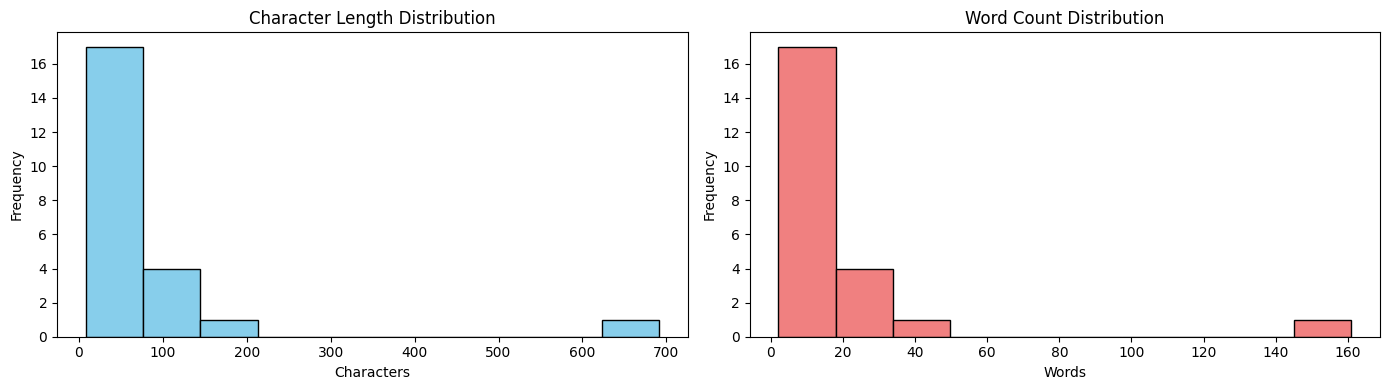

In [14]:
# Analyze characteristics of neutral samples
neutral_df['text_length'] = neutral_df['text'].str.len()
neutral_df['word_count'] = neutral_df['text'].str.split().str.len()

print("Neutral Sample Statistics:")
print(f"Average length: {neutral_df['text_length'].mean():.1f} characters")
print(f"Average words: {neutral_df['word_count'].mean():.1f} words")
print(f"Min length: {neutral_df['text_length'].min()} characters")
print(f"Max length: {neutral_df['text_length'].max()} characters")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(neutral_df['text_length'], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Character Length Distribution')
axes[0].set_xlabel('Characters')
axes[0].set_ylabel('Frequency')

axes[1].hist(neutral_df['word_count'], bins=10, color='lightcoral', edgecolor='black')
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## 3. Phase A: Paraphrase Existing Neutral Samples

Generate 6-7 paraphrases per existing neutral sample to create ~150 augmented samples.


In [23]:
# Paraphrase function
def paraphrase_text(original_text, num_variations=1, temperature=0.8):
    """
    Generate paraphrases of the original text while maintaining neutral sentiment.
    """
    paraphrases = []
    
    system_prompt = """Bạn là chuyên gia viết lại văn bản tiếng Việt cho lĩnh vực ngân hàng.
Nhiệm vụ: Viết lại câu phản hồi/câu hỏi của khách hàng với cùng ý nghĩa nhưng cách diễn đạt khác.
Yêu cầu:
- Giữ nguyên sentiment TRUNG LẬP (neutral - không tích cực, không tiêu cực)
- Viết tự nhiên như khách hàng thật
- Không thêm cảm xúc
- Chỉ trả về câu viết lại, không giải thích"""
    
    user_prompt = f"""Viết lại câu sau với cùng ý nghĩa nhưng cách diễn đạt khác. Giữ nguyên tính trung lập.

Câu gốc: "{original_text}"

Câu viết lại:"""
    
    for i in range(num_variations):
        try:
            response = client.chat.completions.create(
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                model=MODEL_NAME,
                max_tokens=200,
                temperature=temperature + (i * 0.1)  # Increase temperature for more variation
            )
            
            paraphrased = response.choices[0].message.content.strip()
            # Clean up the response
            paraphrased = paraphrased.replace('"', '').replace('Câu viết lại:', '').strip()
            
            if paraphrased and paraphrased != original_text:
                paraphrases.append(paraphrased)
            
            time.sleep(0.3)  # Rate limiting
            
        except Exception as e:
            print(f"Error generating paraphrase {i+1}: {e}")
            continue
    
    return paraphrases

print("✓ Paraphrase function defined")


✓ Paraphrase function defined


In [24]:
# Generate paraphrases for all neutral samples
NUM_PARAPHRASES_PER_SAMPLE = 7  # Target: ~150 samples (23 * 7 = 161)

paraphrased_samples = []

print(f"Starting paraphrase generation for {len(neutral_samples)} samples...")
print(f"Target: {NUM_PARAPHRASES_PER_SAMPLE} variations per sample = ~{len(neutral_samples) * NUM_PARAPHRASES_PER_SAMPLE} total\n")

for idx, original_text in enumerate(tqdm(neutral_samples, desc="Paraphrasing")):
    variations = paraphrase_text(original_text, num_variations=NUM_PARAPHRASES_PER_SAMPLE, temperature=0.8)
    
    for variation in variations:
        paraphrased_samples.append({
            'text': variation,
            'sentiment': 'neutral',
            'source': 'paraphrase',
            'original_idx': idx,
            'timestamp': datetime.now().isoformat()
        })
    
    # Show progress every 5 samples
    if (idx + 1) % 5 == 0:
        print(f"  Completed {idx + 1}/{len(neutral_samples)} samples, Generated {len(paraphrased_samples)} paraphrases so far")

print(f"\n✓ Paraphrase Phase Complete!")
print(f"Generated {len(paraphrased_samples)} paraphrased samples")


Starting paraphrase generation for 23 samples...
Target: 7 variations per sample = ~161 total



Paraphrasing:  22%|██▏       | 5/23 [00:31<02:24,  8.02s/it]

  Completed 5/23 samples, Generated 35 paraphrases so far


Paraphrasing:  43%|████▎     | 10/23 [02:07<03:50, 17.70s/it]

  Completed 10/23 samples, Generated 70 paraphrases so far


Paraphrasing:  65%|██████▌   | 15/23 [03:42<02:29, 18.63s/it]

  Completed 15/23 samples, Generated 105 paraphrases so far


Paraphrasing:  87%|████████▋ | 20/23 [05:17<00:56, 18.90s/it]

  Completed 20/23 samples, Generated 140 paraphrases so far


Paraphrasing: 100%|██████████| 23/23 [06:17<00:00, 16.40s/it]


✓ Paraphrase Phase Complete!
Generated 161 paraphrased samples


In [25]:
# Display sample paraphrases
print("Sample Paraphrases (First 3 originals with their variations):\n")
print("=" * 100)

for i in range(min(3, len(neutral_samples))):
    print(f"\n📝 Original {i+1}: {neutral_samples[i]}")
    print(f"\nParaphrases:")
    
    sample_paraphrases = [p for p in paraphrased_samples if p['original_idx'] == i]
    for j, para in enumerate(sample_paraphrases[:5], 1):
        print(f"  {j}. {para['text']}")
    
    print("-" * 100)


Sample Paraphrases (First 3 originals with their variations):


📝 Original 1: Chỉ lợi ban đầu thui

Paraphrases:
  1. Chỉ có lợi nhuận ngắn hạn.
  2. Không hẳn lợi nhuận ban đầu sẽ bền chặt về lâu dài.

Hoặc:

Lợi nhuận ban đầu có thể không lâu dài.

Hoặc:

Không chắc lợi nhuận ban đầu có thể tồn tại mãi.
  3. Tôi không thấy lợi ích rõ ràng ngay lập tức.
  4. Không có nhiều lợi ích lâu dài từ việc đó.
  5. Không thấy gì khác ngoài lợi nhuận ban đầu.
----------------------------------------------------------------------------------------------------

📝 Original 2: 😂😂😂 phát hờn

Paraphrases:
  1. Tôi không hiểu tại sao việc này lại xảy ra.
  2. Tôi hoàn toàn không hiểu tại sao việc này lại xảy ra.
  3. Đó không thể xảy ra được.
  4. Không hiểu sao lại xảy ra việc này!

 Hoặc: Tôi thật sự không hiểu được lý do này

 Hoặc: Tất nhiên là tôi không hài lòng với tình huống này
  5. Tôi khá ngạc nhiên.
---------------------------------------------------------------------------------------------

## 4. Phase B: Generate New Neutral Samples

Generate completely new neutral banking feedback based on common scenarios.


In [27]:
# Define neutral topics/scenarios for banking feedback
neutral_topics = [
    "hỏi về thủ tục mở tài khoản",
    "hỏi về giờ làm việc của ngân hàng",
    "hỏi về loại thẻ ngân hàng",
    "hỏi về phí chuyển khoản",
    "hỏi về lãi suất tiết kiệm",
    "xác nhận thông tin giao dịch",
    "hỏi về điều kiện vay vốn",
    "hỏi về cách đăng ký internet banking",
    "hỏi về địa chỉ chi nhánh",
    "hỏi về hạn mức thẻ tín dụng",
    "thắc mắc về sao kê tài khoản",
    "hỏi về cách nạp tiền vào tài khoản",
    "hỏi về quy trình đóng/mở sổ tiết kiệm",
    "hỏi về chứng từ giao dịch",
    "hỏi về ứng dụng mobile banking",
    "thắc mắc về hình thức thanh toán",
    "hỏi về việc liên kết tài khoản",
    "hỏi về quy định đổi PIN",
    "thắc mắc về thời gian xử lý giao dịch",
    "hỏi về dịch vụ chuyển tiền nhanh",
]

print(f"✓ Defined {len(neutral_topics)} neutral topics for generation")


✓ Defined 20 neutral topics for generation


In [28]:
# Generation function
def generate_neutral_text(topic, num_samples=1, temperature=0.9):
    """
    Generate completely new neutral banking feedback based on a topic.
    """
    generated = []
    
    system_prompt = """Bạn là chuyên gia tạo dữ liệu cho phân tích sentiment ngân hàng.
Nhiệm vụ: Tạo câu phản hồi/câu hỏi của khách hàng về ngân hàng với sentiment TRUNG LẬP.

Yêu cầu:
- Sentiment: TRUNG LẬP (neutral - không tích cực, không tiêu cực)
- Viết tự nhiên như khách hàng thật
- Đa dạng về phong cách (câu hỏi, xác nhận, thông tin)
- Không có cảm xúc mạnh
- Chỉ trả về 1 câu, không giải thích"""
    
    user_prompt = f"""Tạo 1 câu phản hồi/câu hỏi của khách hàng về ngân hàng với đặc điểm:
- Chủ đề: {topic}
- Sentiment: TRUNG LẬP (không tích cực, không tiêu cực)
- Viết ngắn gọn, tự nhiên như khách hàng thật

Chỉ trả về câu, không giải thích:"""
    
    for i in range(num_samples):
        try:
            response = client.chat.completions.create(
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                model=MODEL_NAME,
                max_tokens=150,
                temperature=temperature + (i * 0.05)
            )
            
            generated_text = response.choices[0].message.content.strip()
            # Clean up
            generated_text = generated_text.replace('"', '').strip()
            
            # Skip if too short or looks like an explanation
            if len(generated_text) > 10 and not generated_text.startswith('Đây là'):
                generated.append(generated_text)
            
            time.sleep(0.3)  # Rate limiting
            
        except Exception as e:
            print(f"Error generating sample {i+1}: {e}")
            continue
    
    return generated

print("✓ Generation function defined")


✓ Generation function defined


In [29]:
# Generate new neutral samples
NUM_SAMPLES_PER_TOPIC = 10  # 20 topics * 10 = 200 samples
generated_samples = []

print(f"Starting generation for {len(neutral_topics)} topics...")
print(f"Target: {NUM_SAMPLES_PER_TOPIC} samples per topic = ~{len(neutral_topics) * NUM_SAMPLES_PER_TOPIC} total\n")

for topic_idx, topic in enumerate(tqdm(neutral_topics, desc="Generating")):
    texts = generate_neutral_text(topic, num_samples=NUM_SAMPLES_PER_TOPIC, temperature=0.9)
    
    for text in texts:
        generated_samples.append({
            'text': text,
            'sentiment': 'neutral',
            'source': 'generated',
            'topic': topic,
            'timestamp': datetime.now().isoformat()
        })
    
    # Show progress every 5 topics
    if (topic_idx + 1) % 5 == 0:
        print(f"  Completed {topic_idx + 1}/{len(neutral_topics)} topics, Generated {len(generated_samples)} samples so far")

print(f"\n✓ Generation Phase Complete!")
print(f"Generated {len(generated_samples)} new neutral samples")


Starting generation for 20 topics...
Target: 10 samples per topic = ~200 total



Generating:  25%|██▌       | 5/20 [01:12<04:43, 18.93s/it]

  Completed 5/20 topics, Generated 50 samples so far


Generating:  50%|█████     | 10/20 [03:28<04:20, 26.04s/it]

  Completed 10/20 topics, Generated 100 samples so far


Generating:  75%|███████▌  | 15/20 [05:43<02:14, 26.90s/it]

  Completed 15/20 topics, Generated 150 samples so far


Generating: 100%|██████████| 20/20 [07:58<00:00, 23.94s/it]

  Completed 20/20 topics, Generated 200 samples so far

✓ Generation Phase Complete!
Generated 200 new neutral samples


In [30]:
# Display sample generated texts
print("Sample Generated Texts (10 random samples):\n")
print("=" * 100)

import random
sample_generated = random.sample(generated_samples, min(10, len(generated_samples)))

for i, sample in enumerate(sample_generated, 1):
    print(f"{i}. {sample['text']}")
    print(f"   Topic: {sample['topic']}")
    print()


Sample Generated Texts (10 random samples):

1. Tôi muốn đăng ký tài khoản internet banking, nhưng tôi không biết cách thực hiện.
   Topic: hỏi về cách đăng ký internet banking

2. Tiện tích liên kết tài khoản của ngân hàng có gì không?
   Topic: hỏi về việc liên kết tài khoản

3. Thời gian nào là hợp lý để xử lý giao dịch chuyển tiền?
   Topic: thắc mắc về thời gian xử lý giao dịch

4. Tôi đã nhận được thông tin giao dịch gần đây, nó chính xác không?
   Topic: xác nhận thông tin giao dịch

5. Tôi muốn hỏi lãi suất tiết kiệm của ngân hàng là bao nhiêu?
   Topic: hỏi về lãi suất tiết kiệm

6. Độ tuổi tối đa để vay vốn tại ngân hàng là bao nhiêu?
   Topic: hỏi về điều kiện vay vốn

7. Để mở tài khoản tại ngân hàng, thủ tục như thế nào?
   Topic: hỏi về thủ tục mở tài khoản

8. Có thể tôi đăng ký mở thẻ tín dụng mới không?
   Topic: hỏi về hạn mức thẻ tín dụng

9. Mình muốn hỏi đổi PIN có phải trả phí không?
   Topic: hỏi về quy định đổi PIN

10. Thủ tục mở tài khoản của ngân hàng gồm nhữ

## 5. Quality Control and Deduplication

Apply validation checks, remove duplicates, and filter low-quality samples.


In [31]:
# Combine all augmented samples
all_augmented = paraphrased_samples + generated_samples

print(f"Total augmented samples before QC: {len(all_augmented)}")
print(f"  - Paraphrased: {len(paraphrased_samples)}")
print(f"  - Generated: {len(generated_samples)}")


Total augmented samples before QC: 361
  - Paraphrased: 161
  - Generated: 200


In [32]:
# Quality control functions
def is_valid_sample(text, min_length=10, max_length=500):
    """Check if sample meets basic quality criteria."""
    if not text or not isinstance(text, str):
        return False
    
    text = text.strip()
    
    # Check length
    if len(text) < min_length or len(text) > max_length:
        return False
    
    # Check if it's not just punctuation or numbers
    if text.replace(' ', '').replace('.', '').replace(',', '').replace('?', '').replace('!', '') == '':
        return False
    
    # Check for Vietnamese characters
    vietnamese_chars = 'àáảãạăắằẳẵặâấầẩẫậèéẻẽẹêếềểễệìíỉĩịòóỏõọôốồổỗộơớờởỡợùúủũụưứừửữựỳýỷỹỵđ'
    has_vietnamese = any(c.lower() in vietnamese_chars for c in text)
    
    if not has_vietnamese:
        return False
    
    return True

def remove_duplicates(samples, existing_texts=None):
    """Remove duplicate samples and optionally check against existing texts."""
    seen = set()
    if existing_texts:
        seen.update(t.lower().strip() for t in existing_texts)
    
    unique_samples = []
    duplicates_removed = 0
    
    for sample in samples:
        text = sample['text'].lower().strip()
        
        if text not in seen:
            seen.add(text)
            unique_samples.append(sample)
        else:
            duplicates_removed += 1
    
    print(f"Removed {duplicates_removed} duplicates")
    return unique_samples

print("✓ Quality control functions defined")


✓ Quality control functions defined


In [33]:
# Apply quality control
print("Applying quality control...\n")

# Step 1: Filter by validity
valid_samples = [s for s in all_augmented if is_valid_sample(s['text'])]
print(f"✓ Step 1 - Valid samples: {len(valid_samples)}/{len(all_augmented)}")
print(f"  Removed {len(all_augmented) - len(valid_samples)} invalid samples")

# Step 2: Remove duplicates within augmented data
unique_samples = remove_duplicates(valid_samples)
print(f"✓ Step 2 - After internal deduplication: {len(unique_samples)}")

# Step 3: Check against existing training data (including original neutral samples)
print("\n✓ Step 3 - Checking against existing training data...")
existing_texts = train_df['text'].tolist()
final_samples = remove_duplicates(unique_samples, existing_texts=existing_texts)
print(f"  Final unique samples: {len(final_samples)}")

print(f"\n{'='*80}")
print(f"Quality Control Summary:")
print(f"  Initial augmented samples: {len(all_augmented)}")
print(f"  After validation: {len(valid_samples)} (-{len(all_augmented) - len(valid_samples)})")
print(f"  After deduplication: {len(final_samples)} (-{len(valid_samples) - len(final_samples)})")
print(f"  Final samples to add: {len(final_samples)}")
print(f"{'='*80}")


Applying quality control...

✓ Step 1 - Valid samples: 354/361
  Removed 7 invalid samples
Removed 2 duplicates
✓ Step 2 - After internal deduplication: 352

✓ Step 3 - Checking against existing training data...
Removed 0 duplicates
  Final unique samples: 352

Quality Control Summary:
  Initial augmented samples: 361
  After validation: 354 (-7)
  After deduplication: 352 (-2)
  Final samples to add: 352


In [34]:
# Analyze quality metrics
final_texts = [s['text'] for s in final_samples]
final_lengths = [len(t) for t in final_texts]
final_word_counts = [len(t.split()) for t in final_texts]

print("\nQuality Metrics of Final Augmented Samples:")
print(f"  Average length: {np.mean(final_lengths):.1f} characters")
print(f"  Average word count: {np.mean(final_word_counts):.1f} words")
print(f"  Min length: {min(final_lengths)} characters")
print(f"  Max length: {max(final_lengths)} characters")

# Compare with original neutral samples
print(f"\nComparison with Original Neutral Samples:")
print(f"  Original - Avg length: {neutral_df['text_length'].mean():.1f} chars, Avg words: {neutral_df['word_count'].mean():.1f}")
print(f"  Augmented - Avg length: {np.mean(final_lengths):.1f} chars, Avg words: {np.mean(final_word_counts):.1f}")



Quality Metrics of Final Augmented Samples:
  Average length: 76.5 characters
  Average word count: 17.1 words
  Min length: 16 characters
  Max length: 360 characters

Comparison with Original Neutral Samples:
  Original - Avg length: 76.2 chars, Avg words: 17.9
  Augmented - Avg length: 76.5 chars, Avg words: 17.1


## 6. Save Augmented Data

Save the augmented neutral samples to `data/neutral_augmented.jsonl` for review.


In [35]:
# Prepare data for saving (keep only text and sentiment for consistency with original format)
output_file = '../data/neutral_augmented.jsonl'

print(f"Saving {len(final_samples)} augmented samples to {output_file}...")

# Save with metadata in comments for tracking
with open(output_file, 'w', encoding='utf-8') as f:
    # Write metadata as comment (optional, can be removed)
    metadata = {
        'generation_date': datetime.now().isoformat(),
        'total_samples': len(final_samples),
        'paraphrased_count': sum(1 for s in final_samples if s['source'] == 'paraphrase'),
        'generated_count': sum(1 for s in final_samples if s['source'] == 'generated'),
        'model': MODEL_NAME
    }
    f.write(f"# Metadata: {json.dumps(metadata, ensure_ascii=False)}\n")
    
    # Write samples in JSONL format
    for sample in final_samples:
        output_sample = {
            'text': sample['text'],
            'sentiment': sample['sentiment']
        }
        f.write(json.dumps(output_sample, ensure_ascii=False) + '\n')

print(f"✓ Successfully saved {len(final_samples)} samples to {output_file}")

# Verify the file
with open(output_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    data_lines = [l for l in lines if not l.startswith('#')]
    print(f"✓ Verification: File contains {len(data_lines)} data lines")


Saving 352 augmented samples to ../data/neutral_augmented.jsonl...
✓ Successfully saved 352 samples to ../data/neutral_augmented.jsonl
✓ Verification: File contains 352 data lines


In [36]:
# Display first 10 samples from saved file
print("First 10 samples from saved file:")
print("=" * 100)

with open(output_file, 'r', encoding='utf-8') as f:
    count = 0
    for line in f:
        if not line.startswith('#'):
            data = json.loads(line)
            count += 1
            print(f"{count}. {data['text']}")
            if count >= 10:
                break


First 10 samples from saved file:
1. Chỉ có lợi nhuận ngắn hạn.
2. Không hẳn lợi nhuận ban đầu sẽ bền chặt về lâu dài.

Hoặc:

Lợi nhuận ban đầu có thể không lâu dài.

Hoặc:

Không chắc lợi nhuận ban đầu có thể tồn tại mãi.
3. Tôi không thấy lợi ích rõ ràng ngay lập tức.
4. Không có nhiều lợi ích lâu dài từ việc đó.
5. Không thấy gì khác ngoài lợi nhuận ban đầu.
6. Cứu vãn một chút lợi nhuận thôi
7. Tác động ngắn hạn có vẻ có lợi.
8. Tôi không hiểu tại sao việc này lại xảy ra.
9. Tôi hoàn toàn không hiểu tại sao việc này lại xảy ra.
10. Đó không thể xảy ra được.


## 7. Analysis and Visualization

Analyze the augmented dataset and visualize the impact on class distribution.


In [37]:
# Create summary statistics
print("=" * 100)
print("AUGMENTATION SUMMARY")
print("=" * 100)

print(f"\n📊 Original Dataset:")
print(f"  - Total samples: {len(train_df)}")
print(f"  - Positive: {len(train_df[train_df['sentiment']=='positive'])} ({len(train_df[train_df['sentiment']=='positive'])/len(train_df)*100:.2f}%)")
print(f"  - Negative: {len(train_df[train_df['sentiment']=='negative'])} ({len(train_df[train_df['sentiment']=='negative'])/len(train_df)*100:.2f}%)")
print(f"  - Neutral: {len(train_df[train_df['sentiment']=='neutral'])} ({len(train_df[train_df['sentiment']=='neutral'])/len(train_df)*100:.2f}%)")

print(f"\n🎯 Augmented Neutral Samples:")
print(f"  - Total augmented: {len(final_samples)}")
print(f"  - From paraphrasing: {sum(1 for s in final_samples if s['source'] == 'paraphrase')}")
print(f"  - From generation: {sum(1 for s in final_samples if s['source'] == 'generated')}")

# Calculate new distribution if augmented samples are added
total_with_aug = len(train_df) + len(final_samples)
pos_count = len(train_df[train_df['sentiment']=='positive'])
neg_count = len(train_df[train_df['sentiment']=='negative'])
neu_count = len(train_df[train_df['sentiment']=='neutral']) + len(final_samples)

print(f"\n📈 New Dataset (if augmented samples are added):")
print(f"  - Total samples: {total_with_aug}")
print(f"  - Positive: {pos_count} ({pos_count/total_with_aug*100:.2f}%)")
print(f"  - Negative: {neg_count} ({neg_count/total_with_aug*100:.2f}%)")
print(f"  - Neutral: {neu_count} ({neu_count/total_with_aug*100:.2f}%)")

print(f"\n✨ Impact:")
print(f"  - Neutral class increased by {len(final_samples)} samples")
print(f"  - Neutral percentage: {len(train_df[train_df['sentiment']=='neutral'])/len(train_df)*100:.2f}% → {neu_count/total_with_aug*100:.2f}%")
print(f"  - Improvement: +{neu_count/total_with_aug*100 - len(train_df[train_df['sentiment']=='neutral'])/len(train_df)*100:.2f} percentage points")
print("=" * 100)


AUGMENTATION SUMMARY

📊 Original Dataset:
  - Total samples: 1977
  - Positive: 1211 (61.25%)
  - Negative: 743 (37.58%)
  - Neutral: 23 (1.16%)

🎯 Augmented Neutral Samples:
  - Total augmented: 352
  - From paraphrasing: 154
  - From generation: 198

📈 New Dataset (if augmented samples are added):
  - Total samples: 2329
  - Positive: 1211 (52.00%)
  - Negative: 743 (31.90%)
  - Neutral: 375 (16.10%)

✨ Impact:
  - Neutral class increased by 352 samples
  - Neutral percentage: 1.16% → 16.10%
  - Improvement: +14.94 percentage points


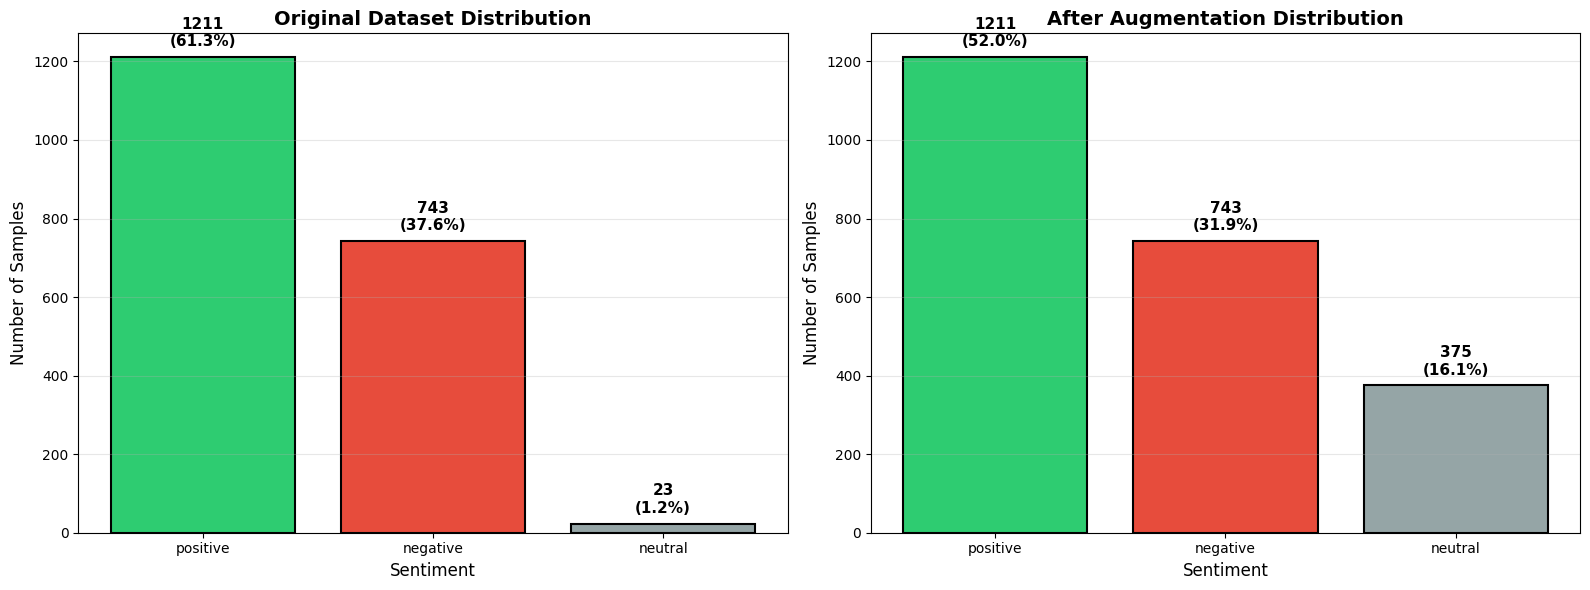

In [38]:
# Visualization 1: Class Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original distribution
original_counts = train_df['sentiment'].value_counts()
colors_orig = ['#2ecc71', '#e74c3c', '#95a5a6']  # green, red, gray

axes[0].bar(original_counts.index, original_counts.values, color=colors_orig, edgecolor='black', linewidth=1.5)
axes[0].set_title('Original Dataset Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (label, value) in enumerate(original_counts.items()):
    percentage = value / len(train_df) * 100
    axes[0].text(i, value + 20, f'{value}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# New distribution with augmented data
new_counts = pd.Series({
    'positive': pos_count,
    'negative': neg_count,
    'neutral': neu_count
})

axes[1].bar(new_counts.index, new_counts.values, color=colors_orig, edgecolor='black', linewidth=1.5)
axes[1].set_title('After Augmentation Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (label, value) in enumerate(new_counts.items()):
    percentage = value / total_with_aug * 100
    axes[1].text(i, value + 20, f'{value}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


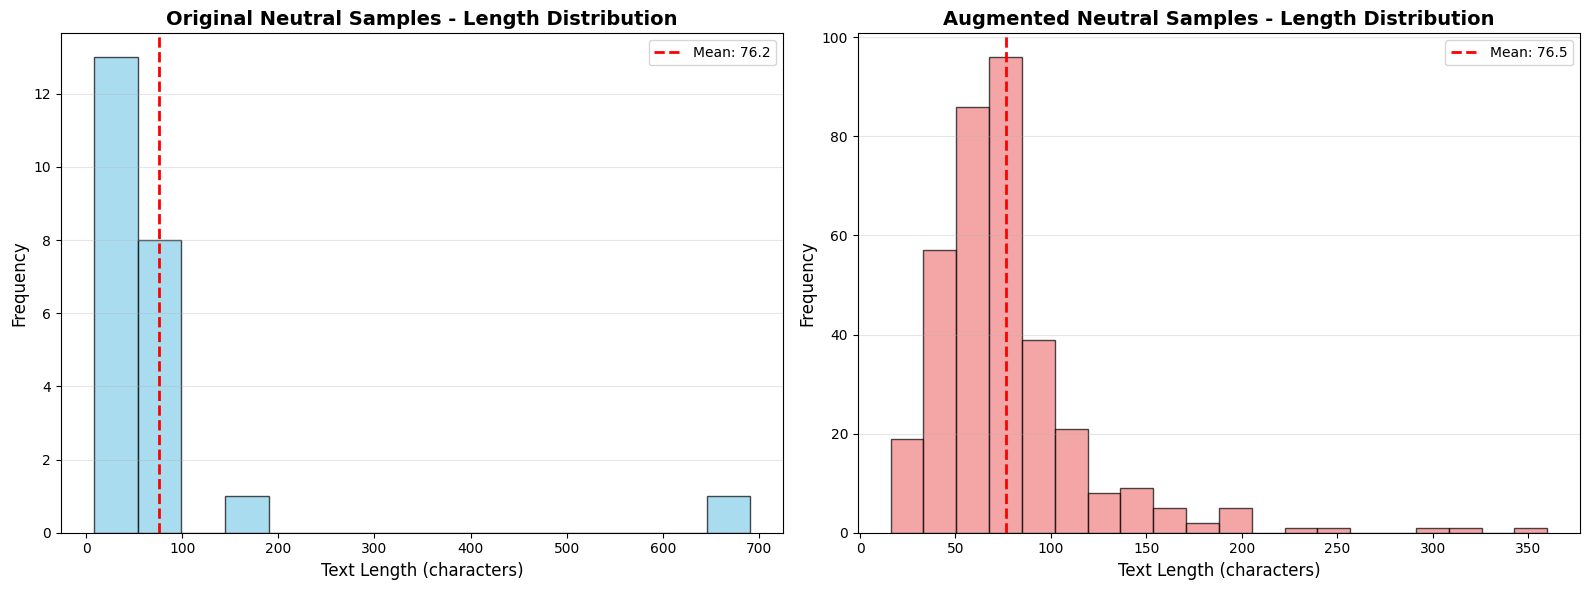

In [39]:
# Visualization 2: Text Length Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original neutral samples
axes[0].hist(neutral_df['text_length'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(neutral_df['text_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {neutral_df["text_length"].mean():.1f}')
axes[0].set_title('Original Neutral Samples - Length Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Text Length (characters)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Augmented neutral samples
axes[1].hist(final_lengths, bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(final_lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(final_lengths):.1f}')
axes[1].set_title('Augmented Neutral Samples - Length Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Text Length (characters)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


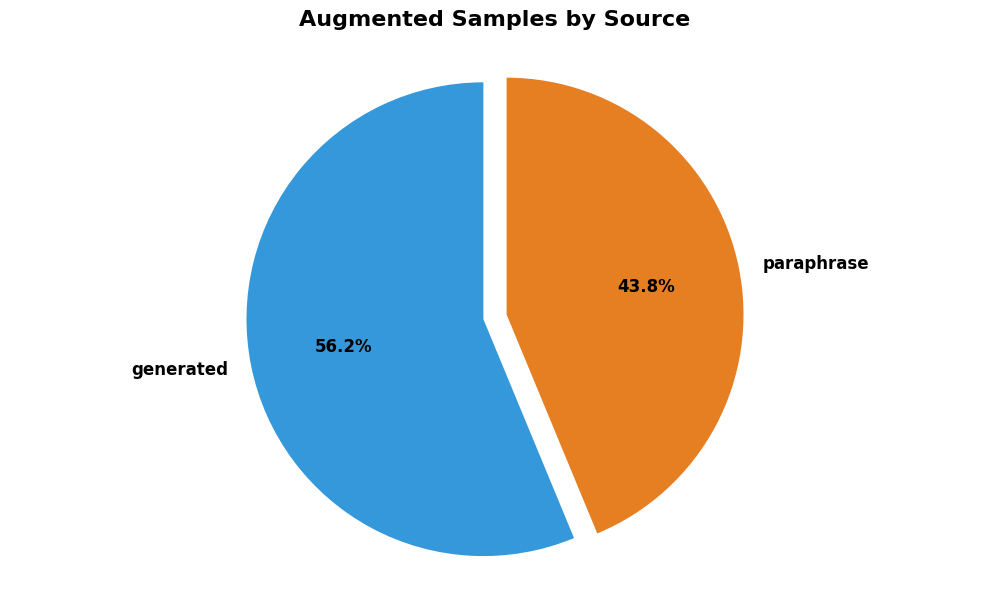


Source Breakdown:
  - Generated: 198 samples (56.2%)
  - Paraphrase: 154 samples (43.8%)


In [40]:
# Visualization 3: Source breakdown
source_counts = pd.Series([s['source'] for s in final_samples]).value_counts()

plt.figure(figsize=(10, 6))
colors = ['#3498db', '#e67e22']
plt.pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'},
        explode=[0.05, 0.05])
plt.title('Augmented Samples by Source', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"\nSource Breakdown:")
for source, count in source_counts.items():
    print(f"  - {source.capitalize()}: {count} samples ({count/len(final_samples)*100:.1f}%)")


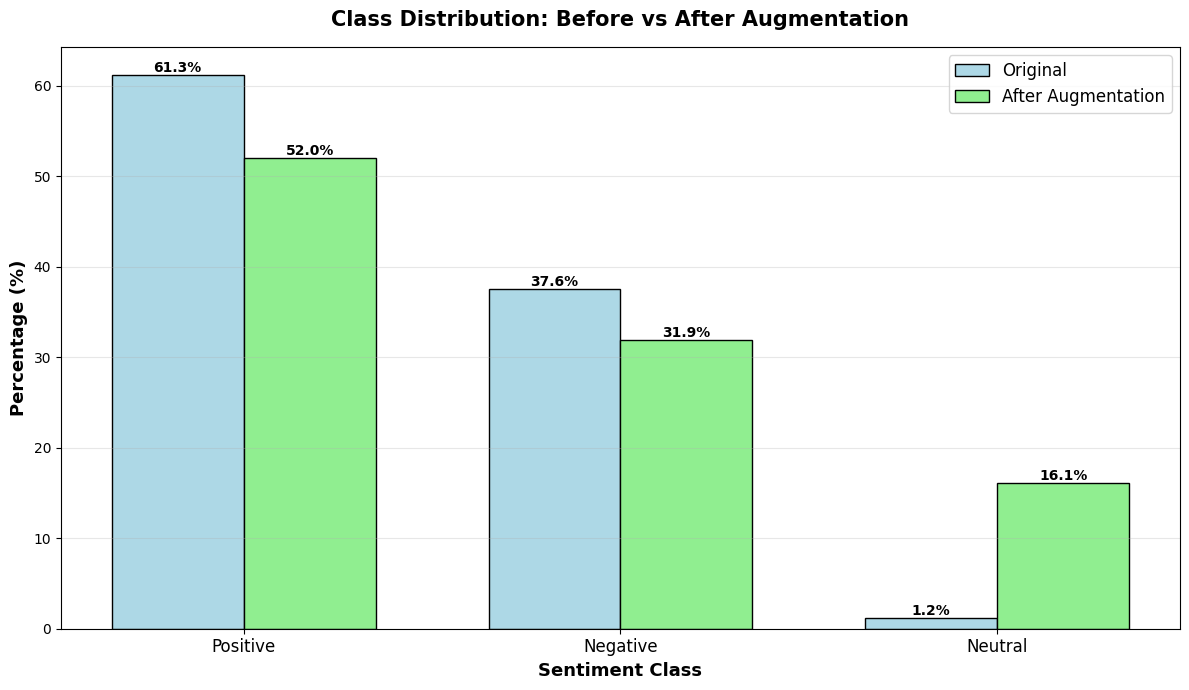

In [41]:
# Visualization 4: Percentage comparison
categories = ['Positive', 'Negative', 'Neutral']
original_pct = [
    len(train_df[train_df['sentiment']=='positive'])/len(train_df)*100,
    len(train_df[train_df['sentiment']=='negative'])/len(train_df)*100,
    len(train_df[train_df['sentiment']=='neutral'])/len(train_df)*100
]
new_pct = [
    pos_count/total_with_aug*100,
    neg_count/total_with_aug*100,
    neu_count/total_with_aug*100
]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, original_pct, width, label='Original', color='lightblue', edgecolor='black')
bars2 = ax.bar(x + width/2, new_pct, width, label='After Augmentation', color='lightgreen', edgecolor='black')

ax.set_xlabel('Sentiment Class', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
ax.set_title('Class Distribution: Before vs After Augmentation', fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## 8. Merge with Original Training Data




In [42]:
# Create new merged file: train_augmentation.jsonl
# This keeps the original train.jsonl intact

import shutil

print("Creating merged training dataset...")
print("=" * 80)

# Read original training data
original_train = []
with open('../data/train.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        original_train.append(json.loads(line))

print(f"✓ Loaded {len(original_train)} samples from original train.jsonl")
print(f"✓ Adding {len(final_samples)} augmented neutral samples")

# Create new merged file
output_merged = '../data/train_augmented.jsonl'

with open(output_merged, 'w', encoding='utf-8') as f:
    # Write original samples first
    for sample in original_train:
        f.write(json.dumps(sample, ensure_ascii=False) + '\n')
    
    # Append augmented samples
    for sample in final_samples:
        output_sample = {
            'text': sample['text'],
            'sentiment': sample['sentiment']
        }
        f.write(json.dumps(output_sample, ensure_ascii=False) + '\n')

print(f"\n✓ Successfully created merged file: {output_merged}")
print(f"✓ Total samples in new file: {len(original_train) + len(final_samples)}")

# Verify the new file
merged_df = load_data(output_merged)
print(f"\n📊 New Dataset Distribution:")
print(merged_df['sentiment'].value_counts())
print(f"\nPercentage:")
print((merged_df['sentiment'].value_counts(normalize=True) * 100).round(2))

print(f"\n{'='*80}")
print("✅ DONE!")
print(f"Original file: ../data/train.jsonl (UNCHANGED)")
print(f"New merged file: {output_merged}")
print(f"\n💡 Next steps:")
print("  1. Use train_augmented.jsonl for training instead of train.jsonl")
print("  2. Update your preprocessing/training scripts to use the new file")
print("  3. Or copy train_augmented.jsonl to train.jsonl when ready")
print("=" * 80)

Creating merged training dataset...
✓ Loaded 1977 samples from original train.jsonl
✓ Adding 352 augmented neutral samples

✓ Successfully created merged file: ../data/train_augmented.jsonl
✓ Total samples in new file: 2329

📊 New Dataset Distribution:
sentiment
positive    1211
negative     743
neutral      375
Name: count, dtype: int64

Percentage:
sentiment
positive    52.0
negative    31.9
neutral     16.1
Name: proportion, dtype: float64

✅ DONE!
Original file: ../data/train.jsonl (UNCHANGED)
New merged file: ../data/train_augmented.jsonl

💡 Next steps:
  1. Use train_augmented.jsonl for training instead of train.jsonl
  2. Update your preprocessing/training scripts to use the new file
  3. Or copy train_augmented.jsonl to train.jsonl when ready
